# 图像分类数据集
:label:`sec_fashion_mnist`

目前广泛使用的图像分类数据集之一是 MNIST 数据集 :cite:`LeCun.Bottou.Bengio.ea.1998`。虽然它是很不错的基准数据集，但按今天的标准，即使是简单的模型也能达到95%以上的分类准确率，因此不适合区分强模型和弱模型。如今，MNIST更像是一个健全检查，而不是一个基准。
为了提高难度，我们将在接下来的章节中讨论在2017年发布的性质相似但相对复杂的Fashion-MNIST数据集 :cite:`Xiao.Rasul.Vollgraf.2017`。


In [1]:
%matplotlib inline
import sys
from mxnet import gluon
from d2l import mxnet as d2l

d2l.use_svg_display()


## 读取数据集

我们可以通过框架中的内置函数将 Fashion-MNIST 数据集下载并读取到内存中。


In [2]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

Fashion-MNIST 由 10 个类别的图像组成，每个类别由训练数据集中的 6000 张图像和测试数据集中的 1000 张图像组成。*测试数据集*（test dataset）不会用于训练，只用于评估模型性能。训练集和测试集分别包含 60000 和 10000 张图像。


In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

每个输入图像的高度和宽度均为 28 像素。数据集由灰度图像组成，其通道数为1。为了简洁起见，在这本书中，我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或($h$, $w$)。


In [4]:
mnist_train[0][0].shape

(28, 28, 1)

Fashion-MNIST中包含的10个类别分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数用于在数字标签索引及其文本名称之间进行转换。


In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。


In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表。"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前几个样本的图像及其相应的标签（文本形式）。


(18, 28, 28, 1)


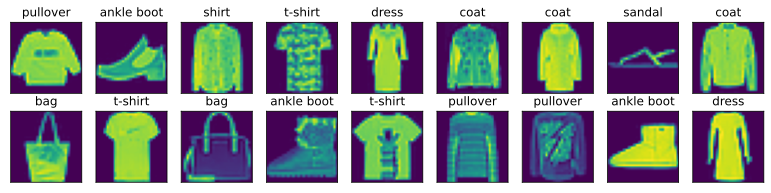

In [7]:
X, y = mnist_train[:18]

print(X.shape)
show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

## 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建一个。
回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为`batch_size`。我们在训练数据迭代器中还随机打乱了所有样本。


In [8]:
batch_size = 256

def get_dataloader_workers():  #@save
    """在非Windows的平台上，使用4个进程来读取的数据。"""
    return 0 if sys.platform.startswith('win') else 4

# 通过ToTensor实例将图像数据从uint8格式变换成32位浮点数格式，并除以255使得所有像素
# 的数值均在0到1之间
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True,
                                   num_workers=get_dataloader_workers())

让我们看一下读取训练数据所需的时间。


In [9]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'2.42 sec'

## 整合所有组件

现在我们定义了 `load_data_fashion_mnist` 函数，用于获取和读取Fashion-MNIST数据集。它返回训练集和验证集的数据迭代器。此外，它还接受一个可选参数，用来将图像大小调整为另一种形状。


In [10]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

下面，我们通过指定`resize`参数来测试`load_data_fashion_mnist`函数的图像大小调整功能。


In [11]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 1, 64, 64) <class 'numpy.float32'> (32,) <class 'numpy.int32'>


我们现在已经准备好在下面的章节中使用Fashion-MNIST数据集。

## 小结

* Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
* 我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或($h$, $w$)。
* 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。

## 练习

1. 减少 `batch_size`（如减少到 1）是否会影响读取性能？
1. 数据迭代器的性能非常重要。你认为当前的实现足够快吗？探索各种选择来改进它。
1. 查阅框架的在线API文档。还有哪些其他数据集可用？


[Discussions](https://discuss.d2l.ai/t/1788)
